# Laboratio 2 - Clustering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib import cm
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot
import scipy.cluster.hierarchy as sch

#Librerias para graficar
import seaborn as sns
import matplotlib.pyplot as plt

#Ignorar warnings
import warnings
#.filterwarnings('ignore')

In [2]:
from IPython.display import display, HTML
from sklearn.tree import _tree, DecisionTreeClassifier
import pandas as pd

def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

def get_class_rules(tree: DecisionTreeClassifier, feature_names: list):
  inner_tree: _tree.Tree = tree.tree_
  classes = tree.classes_
  class_rules_dict = dict()

  def tree_dfs(node_id=0, current_rule=[]):
    # feature[i] holds the feature to split on, for the internal node i.
    split_feature = inner_tree.feature[node_id]
    if split_feature != _tree.TREE_UNDEFINED: # internal node
      name = feature_names[split_feature]
      threshold = inner_tree.threshold[node_id]
      # left child
      left_rule = current_rule + ["({} <= {})".format(name, threshold)]
      tree_dfs(inner_tree.children_left[node_id], left_rule)
      # right child
      right_rule = current_rule + ["({} > {})".format(name, threshold)]
      tree_dfs(inner_tree.children_right[node_id], right_rule)
    else: # leaf
      dist = inner_tree.value[node_id][0]
      dist = dist/dist.sum()
      max_idx = dist.argmax()
      if len(current_rule) == 0:
        rule_string = "ALL"
      else:
        rule_string = " and ".join(current_rule)
      # register new rule to dictionary
      selected_class = classes[max_idx]
      class_probability = dist[max_idx]
      class_rules = class_rules_dict.get(selected_class, [])
      class_rules.append((rule_string, class_probability))
      class_rules_dict[selected_class] = class_rules
    
  tree_dfs() # start from root, node_id = 0
  return class_rules_dict

def cluster_report(data: pd.DataFrame, clusters, min_samples_leaf=50, pruning_level=0.01):
    # Create Model
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf, ccp_alpha=pruning_level)
    tree.fit(data, clusters)
    
    # Generate Report
    feature_names = data.columns
    class_rule_dict = get_class_rules(tree, feature_names)

    report_class_list = []
    for class_name in class_rule_dict.keys():
        rule_list = class_rule_dict[class_name]
        combined_string = ""
        for rule in rule_list:
            combined_string += "[{}] {}\n\n".format(rule[1], rule[0])
        report_class_list.append((class_name, combined_string))
        
    cluster_instance_df = pd.Series(clusters).value_counts().reset_index()
    cluster_instance_df.columns = ['class_name', 'instance_count']
    report_df = pd.DataFrame(report_class_list, columns=['class_name', 'rule_list'])
    report_df = pd.merge(cluster_instance_df, report_df, on='class_name', how='left')
    pretty_print(report_df.sort_values(by='class_name')[['class_name', 'instance_count', 'rule_list']])


In [3]:
data = pd.read_csv("data/202120_Laboratorio_2_datos_BancAlpes_credit_card_data.csv",sep=";", index_col="Id", na_values=["?","-"])
data

,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Id,,,,,,,,,,
1,87073.0,20000.0,Female,2,Married,24.0,2.0,1.0,1.0,0.0
2,38414.0,120000.0,Female,2,Single,26.0,3.0,0.0,10.0,9.0
3,17341.0,90000.0,Female,2,Single,34.0,7.0,1.0,3.0,4.0
4,40496.0,50000.0,Female,2,Married,37.0,5.0,1.0,1.0,NaN
5,47437.0,50000.0,Male,2,Married,57.0,6.0,0.0,12.0,3.0
...,...,...,...,...,...,...,...,...,...,...
656,51108.0,280000.0,Male,2,Married,39.0,10.0,1.0,10.0,0.0
657,60732.0,290000.0,Female,3,Single,27.0,10.0,1.0,13.0,2.0
658,53834.0,190000.0,Female,1,Single,28.0,8.0,1.0,9.0,1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 1 to 660
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer             658 non-null    float64
 1   Limit_bal            659 non-null    float64
 2   Sex                  659 non-null    object 
 3   Education            659 non-null    object 
 4   Marriage             657 non-null    object 
 5   Age                  659 non-null    float64
 6   Total_Credit_Cards   658 non-null    float64
 7   Total_visits_bank    656 non-null    float64
 8   Total_visits_online  659 non-null    float64
 9   Total_calls_made     658 non-null    float64
dtypes: float64(7), object(3)
memory usage: 56.7+ KB


### Exploración de columnas

#### Transformación de columnas cualitativas

Data antes del procesamiento
 Female    372
Male      273
Mael        3
M           3
F           3
f           2
Femael      1
Fmale       1
9           1
Name: Sex, dtype: int64
Data después del procesamiento



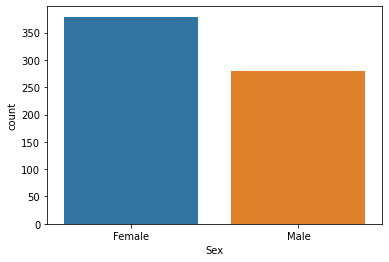

In [5]:
print("Data antes del procesamiento\n",data["Sex"].value_counts())
data["Sex"] = data["Sex"].replace("M","Male")
data["Sex"] = data["Sex"].replace("M ","Male")
data["Sex"] = data["Sex"].replace("Mael","Male")
data["Sex"] = data["Sex"].replace("F","Female")
data["Sex"] = data["Sex"].replace("f","Female")
data["Sex"] = data["Sex"].replace("Fmale","Female")
data["Sex"] = data["Sex"].replace("Femael","Female")
data["Sex"] = data["Sex"].replace("9",np.nan)
print("Data después del procesamiento\n")
ax = sns.countplot(x="Sex", data=data)

Data antes del procesamiento
 2      288
1      264
3       99
5        3
6        2
4        2
ABC      1
Name: Education, dtype: int64
Data después del procesamiento



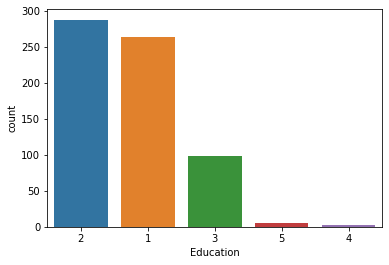

In [6]:
print("Data antes del procesamiento\n",data["Education"].value_counts())
data["Education"] = data["Education"].replace("ABC",np.nan)
data["Education"] = data["Education"].replace("6","5")
print("Data después del procesamiento\n")
ax = sns.countplot(x="Education", data=data)

Data antes del procesamiento
 Single     379
Married    260
Others       9
1            5
2            3
0            1
Name: Marriage, dtype: int64
Data después del procesamiento



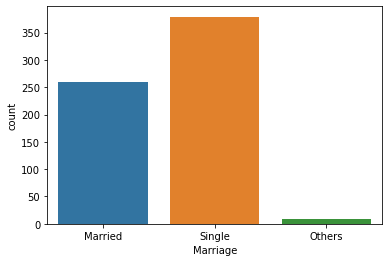

In [7]:
print("Data antes del procesamiento\n",data["Marriage"].value_counts())
data["Marriage"] = data["Marriage"].replace("1",np.nan)
data["Marriage"] = data["Marriage"].replace("2",np.nan)
data["Marriage"] = data["Marriage"].replace("0",np.nan)
print("Data después del procesamiento\n")
ax = sns.countplot(x="Marriage", data=data)

#### Transformación columnas cuantitativas

In [8]:
data_numeric=data[["Customer","Limit_bal","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]]
data_numeric.describe()

,Customer,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,658.000000,659.000000,659.000000,6.580000e+02,656.00000,659.000000,658.000000
mean,55180.056231,170000.000000,95.218513,1.876290e+05,2.41311,2.602428,3.579027
std,25651.348197,129739.041329,1432.660847,4.812847e+06,1.63130,2.936469,2.868076
min,11265.000000,10000.000000,21.000000,1.000000e+00,0.00000,0.000000,0.000000
25%,33875.500000,50000.000000,28.000000,3.000000e+00,1.00000,1.000000,1.000000
50%,53907.000000,140000.000000,33.000000,5.000000e+00,2.00000,2.000000,3.000000
75%,77321.500000,240000.000000,41.000000,6.000000e+00,4.00000,4.000000,5.000000
max,99843.000000,630000.000000,36745.000000,1.234568e+08,5.00000,15.000000,10.000000


Se puede observar que el máximo de la edad es muy alto teniendo en cuenta la realidad y por lo tanto hay outliers. Se puede observar que el máximo de Total_credi_Cards es muy alto respecto al 75% por lo tanto hay outliers

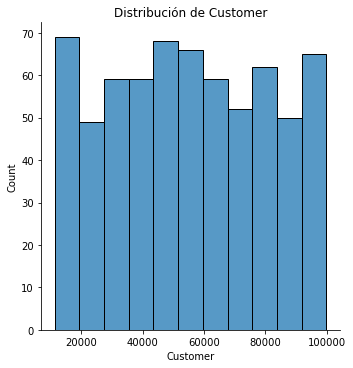

In [9]:
sns.displot(data["Customer"]).set(title="Distribución de Customer");

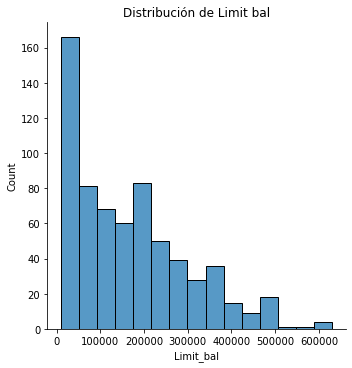

In [10]:
sns.displot(data["Limit_bal"]).set(title="Distribución de Limit bal");

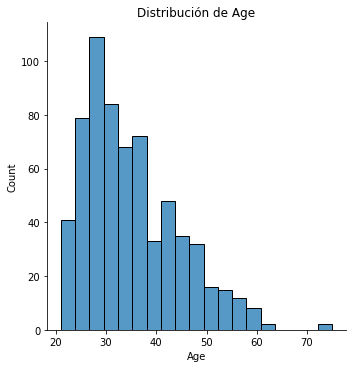

In [11]:
for i in range(0,3):
    data= data[data["Age"] < max(data["Age"])] #Aqui se quietaron los 3 valores más altos
sns.displot(data["Age"]).set(title="Distribución de Age");

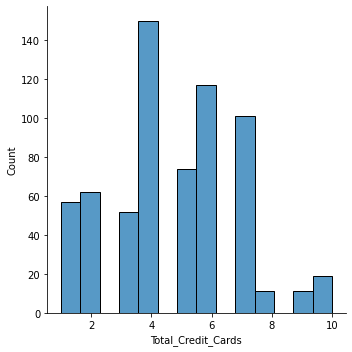

In [12]:
data= data[data["Total_Credit_Cards"] < max(data["Total_Credit_Cards"])] #Aqui se quietaron los 1 valores más altos
sns.displot(data["Total_Credit_Cards"]);

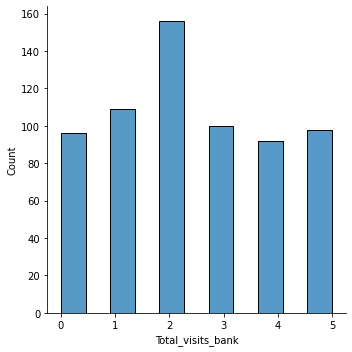

In [13]:
sns.displot(data["Total_visits_bank"]);

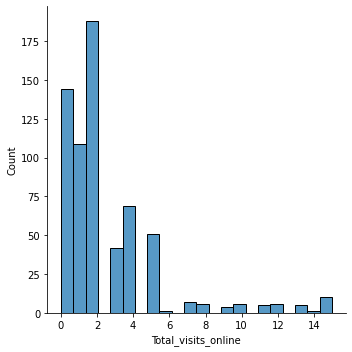

In [14]:
sns.displot(data["Total_visits_online"]);

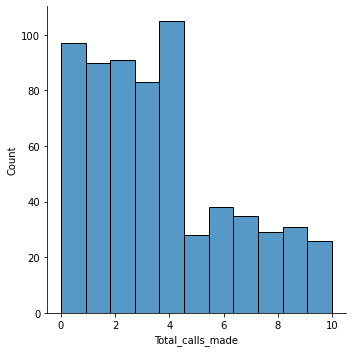

In [15]:
sns.displot(data["Total_calls_made"]);

#### Descripción de columnas numericas

In [16]:
data_numeric=data[["Customer","Limit_bal","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]]
data_numeric.describe()

,Customer,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,653.000000,654.000000,654.000000,654.000000,651.000000,654.000000,653.000000
mean,55117.849923,170137.614679,35.064220,4.729358,2.425499,2.594801,3.560490
std,25659.817546,129589.336139,9.363454,2.161580,1.629128,2.944516,2.865294
min,11265.000000,10000.000000,21.000000,1.000000,0.000000,0.000000,0.000000
25%,33837.000000,52500.000000,28.000000,3.000000,1.000000,1.000000,1.000000
50%,53916.000000,140000.000000,33.000000,5.000000,2.000000,2.000000,3.000000
75%,77143.000000,240000.000000,41.000000,6.000000,4.000000,4.000000,5.000000
max,99843.000000,630000.000000,75.000000,10.000000,5.000000,15.000000,10.000000


En este puonto las variables numericas percen ser normales

Se identifican particiones en la muestra en **Total vistis online vs Total Credit Cards**, **Total vistis online vs Total calls made** , **Total Credit Cards vs. Total vists bank** y **Total calls made vs Total visits online** 

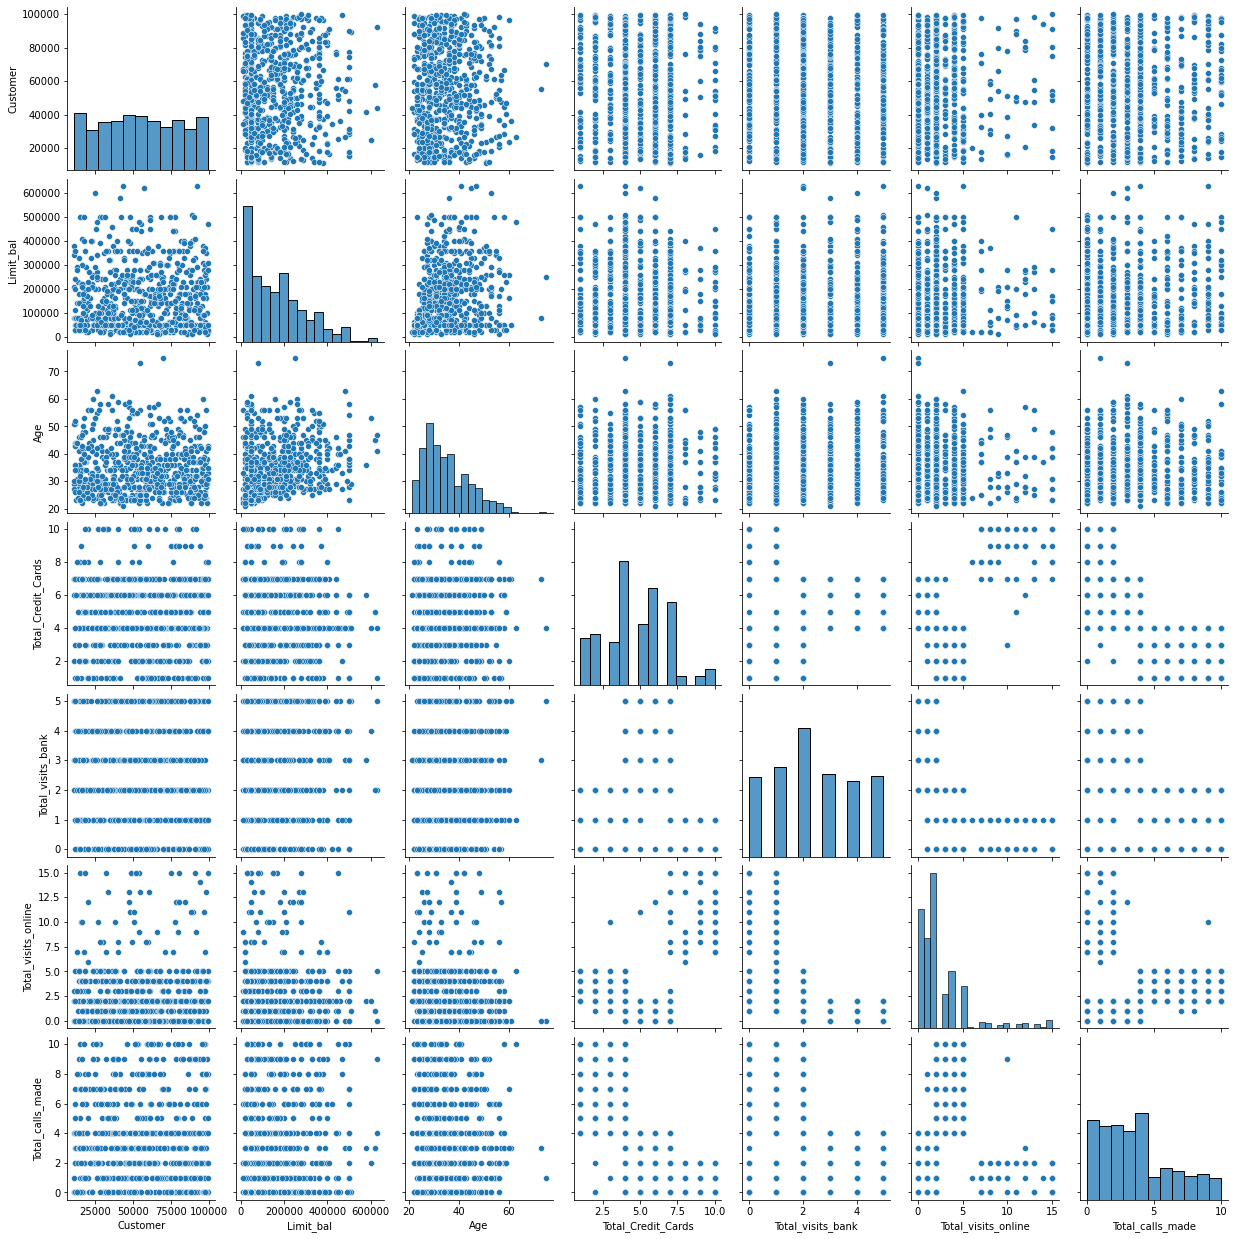

In [17]:
sns.pairplot(data=data_numeric);

### Verificación de NA

In [18]:
data.isna().sum(axis=0)

Customer                1
Limit_bal               0
Sex                     1
Education               1
Marriage               10
Age                     0
Total_Credit_Cards      0
Total_visits_bank       3
Total_visits_online     0
Total_calls_made        1
dtype: int64

In [19]:
data = data.dropna()
data

,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Id,,,,,,,,,,
1,87073.0,20000.0,Female,2,Married,24.0,2.0,1.0,1.0,0.0
2,38414.0,120000.0,Female,2,Single,26.0,3.0,0.0,10.0,9.0
3,17341.0,90000.0,Female,2,Single,34.0,7.0,1.0,3.0,4.0
5,47437.0,50000.0,Male,2,Married,57.0,6.0,0.0,12.0,3.0
6,58634.0,50000.0,Male,1,Single,37.0,3.0,0.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...
656,51108.0,280000.0,Male,2,Married,39.0,10.0,1.0,10.0,0.0
657,60732.0,290000.0,Female,3,Single,27.0,10.0,1.0,13.0,2.0
658,53834.0,190000.0,Female,1,Single,28.0,8.0,1.0,9.0,1.0


### Escalamiento de datos

In [20]:
mms = MinMaxScaler()
data_norm = mms.fit_transform(data[["Limit_bal","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]])
saved_cols = ["Limit_bal","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]
data_norm = pd.DataFrame(data_norm, columns =saved_cols)
data_norm

,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,0.016129,0.055556,0.111111,0.2,0.066667,0.0
1,0.177419,0.092593,0.222222,0.0,0.666667,0.9
2,0.129032,0.240741,0.666667,0.2,0.200000,0.4
3,0.064516,0.666667,0.555556,0.0,0.800000,0.3
4,0.064516,0.296296,0.222222,0.0,0.066667,0.8
...,...,...,...,...,...,...
634,0.435484,0.333333,1.000000,0.2,0.666667,0.0
635,0.451613,0.111111,1.000000,0.2,0.866667,0.2
636,0.290323,0.129630,0.777778,0.2,0.600000,0.1
637,0.112903,0.037037,1.000000,0.2,1.000000,0.0


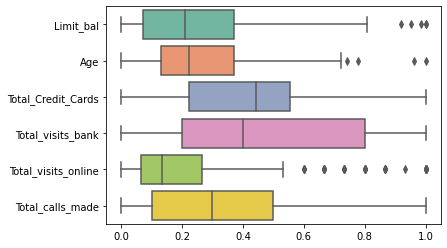

In [21]:
sns.boxplot(data=data_norm[["Limit_bal","Age","Total_Credit_Cards","Total_visits_bank","Total_visits_online","Total_calls_made"]], orient="h", palette="Set2");

### Encoding

In [22]:
enc = OneHotEncoder(handle_unknown='ignore')
labelencoder = LabelEncoder()
sex= labelencoder.fit_transform(data['Sex'])
sex = sex.reshape(len(sex),1)
sex = enc.fit_transform(sex)
sex= pd.DataFrame.sparse.from_spmatrix(sex)
sex = sex.rename(columns={0: 'Female', 1: 'Male'})
sex

,Female,Male
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0
...,...,...
634,0.0,1.0
635,1.0,0.0
636,1.0,0.0
637,1.0,0.0


In [23]:
edu= labelencoder.fit_transform(data['Education'])
edu = edu.reshape(len(edu),1)
edu = enc.fit_transform(edu)
edu= pd.DataFrame.sparse.from_spmatrix(edu)
edu =edu.rename(columns={0: 'L2', 1: 'L1',2:'L3',3:'L5',4:'L4'})
edu

,L2,L1,L3,L5,L4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
634,0.0,1.0,0.0,0.0,0.0
635,0.0,0.0,1.0,0.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,1.0,0.0,0.0,0.0,0.0


In [24]:
marri= labelencoder.fit_transform(data['Marriage'])
marri = marri.reshape(len(marri),1)
marri = enc.fit_transform(marri)
marri= pd.DataFrame.sparse.from_spmatrix(marri)
marri = marri.rename(columns={0: 'Married', 1: 'Single',2:'Others'})
marri

,Married,Single,Others
0,1.0,0.0,0.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0
...,...,...,...
634,1.0,0.0,0.0
635,0.0,0.0,1.0
636,0.0,0.0,1.0
637,0.0,0.0,1.0


In [25]:
data

,Customer,Limit_bal,Sex,Education,Marriage,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
Id,,,,,,,,,,
1,87073.0,20000.0,Female,2,Married,24.0,2.0,1.0,1.0,0.0
2,38414.0,120000.0,Female,2,Single,26.0,3.0,0.0,10.0,9.0
3,17341.0,90000.0,Female,2,Single,34.0,7.0,1.0,3.0,4.0
5,47437.0,50000.0,Male,2,Married,57.0,6.0,0.0,12.0,3.0
6,58634.0,50000.0,Male,1,Single,37.0,3.0,0.0,1.0,8.0
...,...,...,...,...,...,...,...,...,...,...
656,51108.0,280000.0,Male,2,Married,39.0,10.0,1.0,10.0,0.0
657,60732.0,290000.0,Female,3,Single,27.0,10.0,1.0,13.0,2.0
658,53834.0,190000.0,Female,1,Single,28.0,8.0,1.0,9.0,1.0


### Eliminación de columnas

In [26]:
data = data.drop(columns=['Customer'])

### Encoded dataframe

In [27]:
#Mergeaer las columnas de sex 
sex =sex.set_index(data_norm.index)
data_norm["Gender"]=sex["Male"]
#Mergeaer las columnas de education
edu =edu.set_index(data_norm.index)
data_norm[edu.columns]=edu
#Mergeaer las columnas de marriage
marri =marri.set_index(data_norm.index)
data_norm[marri.columns]=marri
#Dropear columas originales
#data_norm=.drop(columns=['Sex','Education','Marriage'])
data_norm

,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Gender,L2,L1,L3,L5,L4,Married,Single,Others
0,0.016129,0.055556,0.111111,0.2,0.066667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.177419,0.092593,0.222222,0.0,0.666667,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.129032,0.240741,0.666667,0.2,0.200000,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.064516,0.666667,0.555556,0.0,0.800000,0.3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.064516,0.296296,0.222222,0.0,0.066667,0.8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,0.435484,0.333333,1.000000,0.2,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
635,0.451613,0.111111,1.000000,0.2,0.866667,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
636,0.290323,0.129630,0.777778,0.2,0.600000,0.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
637,0.112903,0.037037,1.000000,0.2,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Modelos 

In [28]:
def plot_distortion(data,k_min, k_max, ylabel = 'Distortion',xlabel = 'Number of clusters',title = 'Distortion Plot'):
    distortions = []
    for i in range(k_min, k_max):
        km = KMeans(n_clusters=i,
                 init='k-means++',
                 n_init=10,
                 max_iter=300,
                 random_state=0)
        km.fit(data)
        distortions.append(km.inertia_)
    plt.plot(range(k_min,k_max), distortions, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found

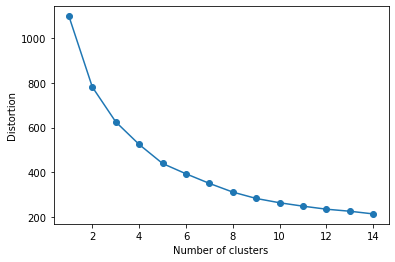

In [29]:
plot_distortion(data_norm,1,15);

In [30]:
def plot_silhouette(data, labels, ylabel = 'Clústeres', xlabel = "Silhouette coefficient", title = 'Silhouette Plot'):

    cluster_labels = np.unique(labels)
    print(cluster_labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(data,
                                        labels,
                                        metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper),
                        c_silhouette_vals,
                        height=1.0,
                        edgecolor='none',
                        color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg,color="red",linestyle="--")
    plt.yticks(yticks, cluster_labels+1)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

### K Means

In [31]:
n_clusters=5
kmeans = KMeans(n_clusters=n_clusters, random_state=0) 
kmeans = kmeans.fit(data_norm)

C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


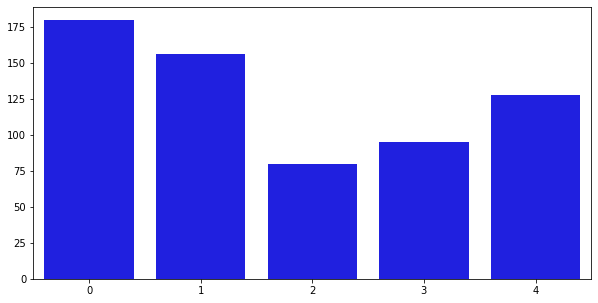

In [32]:
labels = kmeans.labels_
dataKmeans=data_norm
dataKmeans['Cluster'] = labels
cluster_distrib = data_norm['Cluster'].value_counts()
fig=plt.figure(figsize=(10,5))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');


[0 1 2 3 4]


C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


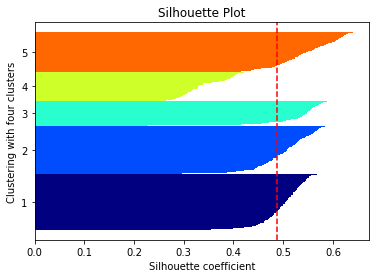

In [33]:
plot_silhouette(data = dataKmeans,  labels = kmeans.labels_, ylabel = 'Clustering with four clusters')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

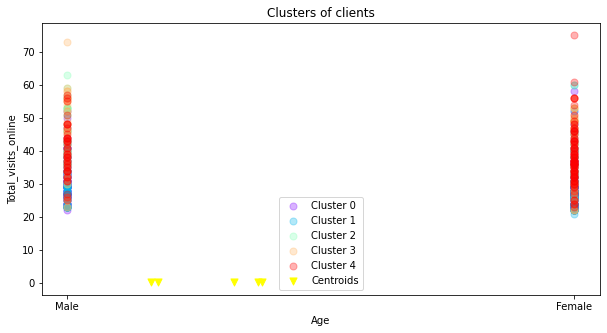

In [34]:
colors = cm.rainbow(np.linspace(0, 1, cluster_distrib.shape[0]))
cols_number = data.to_numpy()
name_cols_number = data_norm.columns
vista_x=1
vista_y=4
fig=plt.figure(figsize=(10,5))
for i in range(0,n_clusters):
    plt.scatter(cols_number[kmeans.labels_ == i, vista_x], cols_number[kmeans.labels_ == i, vista_y], s = 50, c = colors[i], alpha =0.3, label = 'Cluster '+ str(i))

plt.scatter(kmeans.cluster_centers_[:, vista_x], kmeans.cluster_centers_[:, vista_y], s = 50,  marker='v', c = 'yellow', label = 'Centroids')
plt.title('Clusters of clients')
plt.xlabel(name_cols_number[vista_x])
plt.ylabel(name_cols_number[vista_y])
plt.legend()
plt.show();


TypeError: cannot perform var with type Sparse[float64, 0]

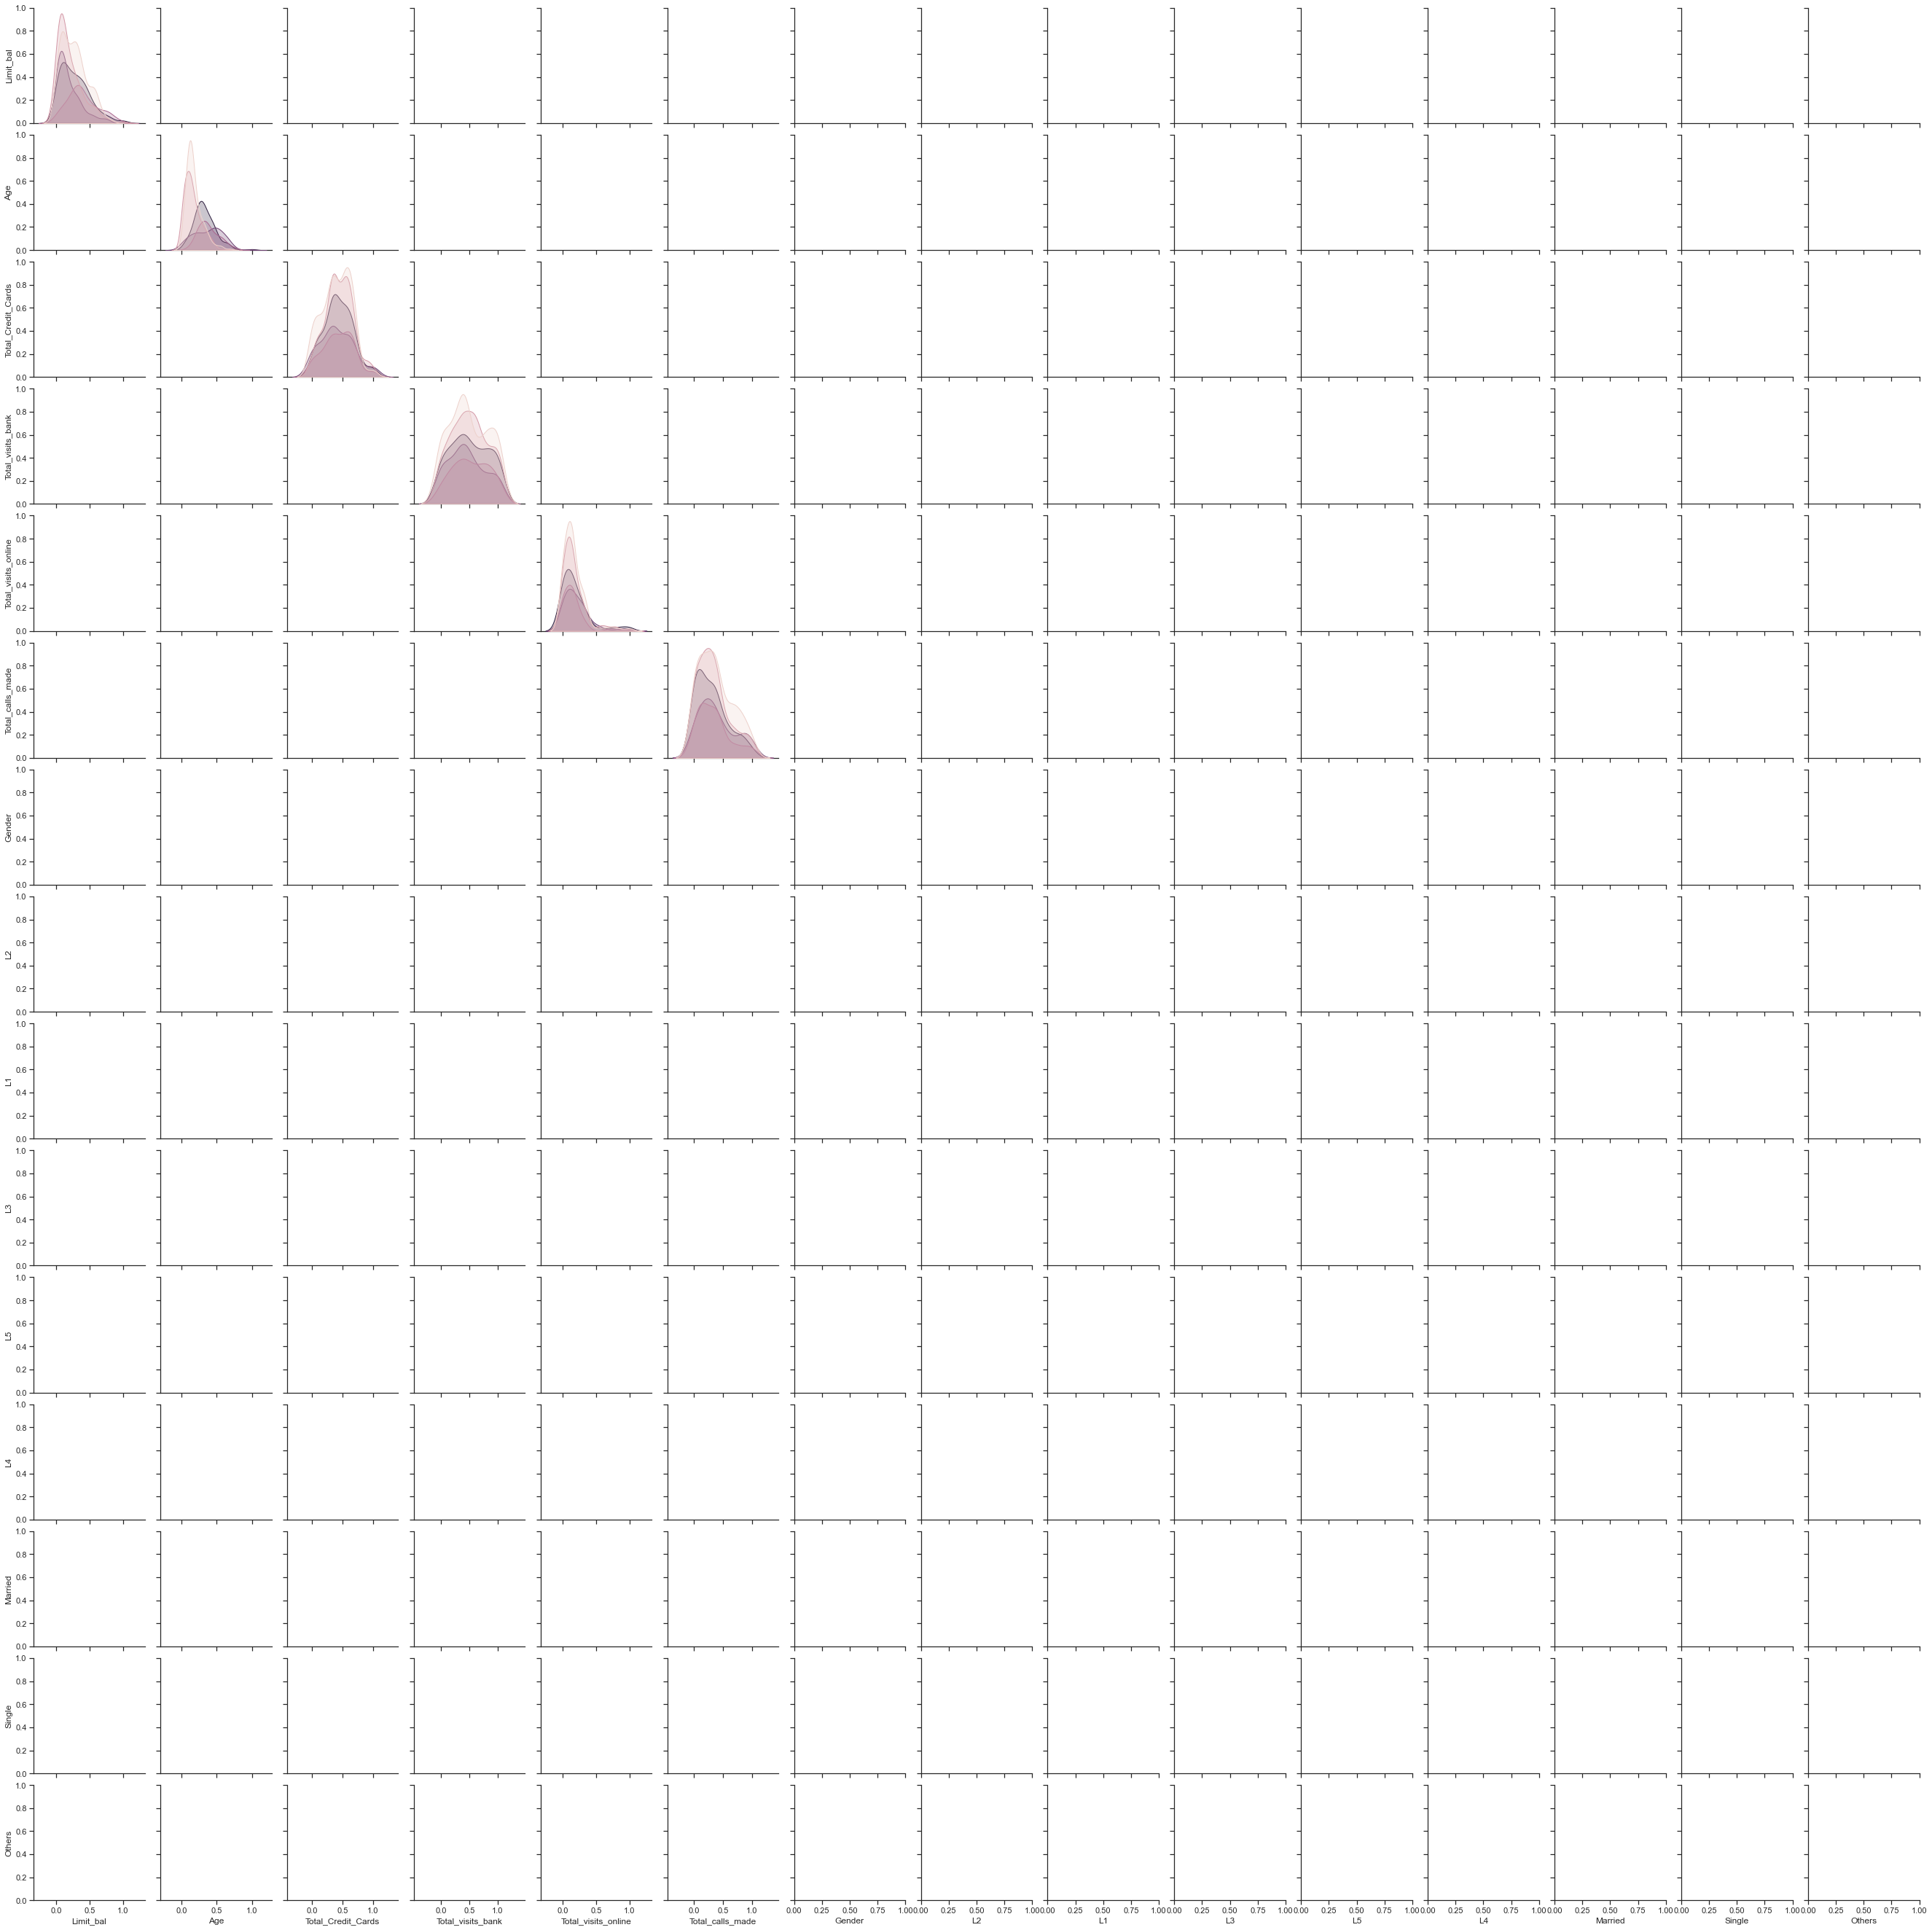

In [35]:
sns.set_theme(style="ticks")
sns.pairplot(dataKmeans, hue="Cluster")

### DBSCAN

In [36]:
range_eps = [0.2,0.3,0.4,0.5,0.7,0.9,1,1.3]
for i in range_eps:
    print("Valor de epsilon es: "+str(i))
    db = DBSCAN(eps=i, min_samples=5).fit(data_norm)
    core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
    core_samples_mask[db.core_sample_indices_]=True
    labels = db.labels_
    print(set(labels))
    silhouette_avg = silhouette_score(data_norm, labels)
    print("Para epsilon ="+ str(i),
         "El promedio silhouette_score es: ", silhouette_avg)

Valor de epsilon es: 0.2
{0, 1, 2, 3, 4, 5, 6, -1}
Para epsilon =0.2 El promedio silhouette_score es:  -0.2691010594523377
Valor de epsilon es: 0.3
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}
Para epsilon =0.3 El promedio silhouette_score es:  -0.05717801910633714
Valor de epsilon es: 0.4
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, -1}
Para epsilon =0.4 El promedio silhouette_score es:  0.22432905079290286
Valor de epsilon es: 0.5
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, -1}
Para epsilon =0.5 El promedio silhouette_score es:  0.327896395589059
Valor de epsilon es: 0.7
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, -1}
Para epsilon =0.7 El promedio silhouette_score es:  0.3757421223617287
Valor de epsilon es: 0.9
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
Para epsilon =0.9 El promedio silhouette_score es:  0.39553417255117734
Valor de epsilon es: 1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, -1}
Para epsilon =1 El promedio silhouette_score es:  0.39626

C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\s

In [37]:
selected_eps=1.3
min_samples = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
for i in min_samples:
    print("Valor de min_samples es "+str(i))
    db= DBSCAN(eps=selected_eps, min_samples=i).fit(data_norm)
    core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
    core_samples_mask[db.core_sample_indices_]=True
    labels=set([label for label in db.labels_ if label>=0])
    print(set(labels))
    print("Para el valor de min_samples = "+str(i),"# total de clusters son "+ str(len(set(labels))))

Valor de min_samples es 1
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}
Para el valor de min_samples = 1 # total de clusters son 14
Valor de min_samples es 2
{0, 1, 2, 3, 4, 5, 6, 7}
Para el valor de min_samples = 2 # total de clusters son 8
Valor de min_samples es 3
{0, 1, 2, 3, 4, 5, 6}
Para el valor de min_samples = 3 # total de clusters son 7
Valor de min_samples es 4
{0, 1, 2, 3, 4, 5, 6}
Para el valor de min_samples = 4 # total de clusters son 7
Valor de min_samples es 5
{0, 1, 2, 3, 4, 5, 6}
Para el valor de min_samples = 5 # total de clusters son 7
Valor de min_samples es 6
{0, 1, 2, 3, 4, 5, 6}
Para el valor de min_samples = 6 # total de clusters son 7
Valor de min_samples es 7
{0, 1, 2, 3, 4, 5}
Para el valor de min_samples = 7 # total de clusters son 6
Valor de min_samples es 8
{0, 1, 2, 3, 4, 5}
Para el valor de min_samples = 8 # total de clusters son 6
Valor de min_samples es 9
{0, 1, 2, 3, 4, 5}
Para el valor de min_samples = 9 # total de clusters son 6
Valor de min_samp

C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
C:\Users\nicoc\anaconda3\lib\s

{0, 1, 2, 3, 4, 5}
Para el valor de min_samples = 23 # total de clusters son 6
Valor de min_samples es 24
{0, 1, 2, 3, 4, 5}
Para el valor de min_samples = 24 # total de clusters son 6


C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [38]:
min_sambles=24
finalDB = DBSCAN(eps=selected_eps, min_samples=min_sambles).fit(data_norm)
core_samples_mask = np.zeros_like(db.labels_,dtype=bool)
core_samples_mask[db.core_sample_indices_]=True
labels= finalDB.labels_
print(set(labels))

n_clusters_ = len(set(labels))
n_noise_ = list(labels).count(-1)

print("# estimado de clusters: %d" % n_clusters_)
print("# estimado de noise points: %d" % n_noise_)

{0, 1, 2, 3, 4, 5, -1}
# estimado de clusters: 7
# estimado de noise points: 14


C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


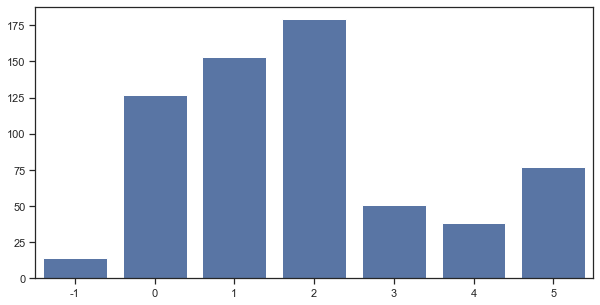

In [39]:
data_DBSCAN=data_norm
data_DBSCAN["Cluster"] =labels
cluster_distrib = data_DBSCAN['Cluster'].value_counts()
fig=plt.figure(figsize=(10,5))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');

[-1  0  1  2  3  4  5]


C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


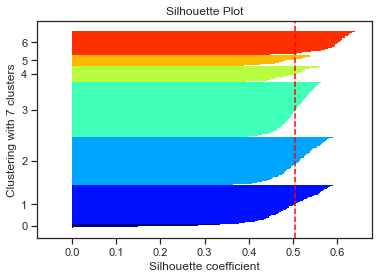

In [40]:
plot_silhouette(data = data_DBSCAN,  labels = labels, ylabel = 'Clustering with 7 clusters')

TypeError: cannot perform var with type Sparse[float64, 0]

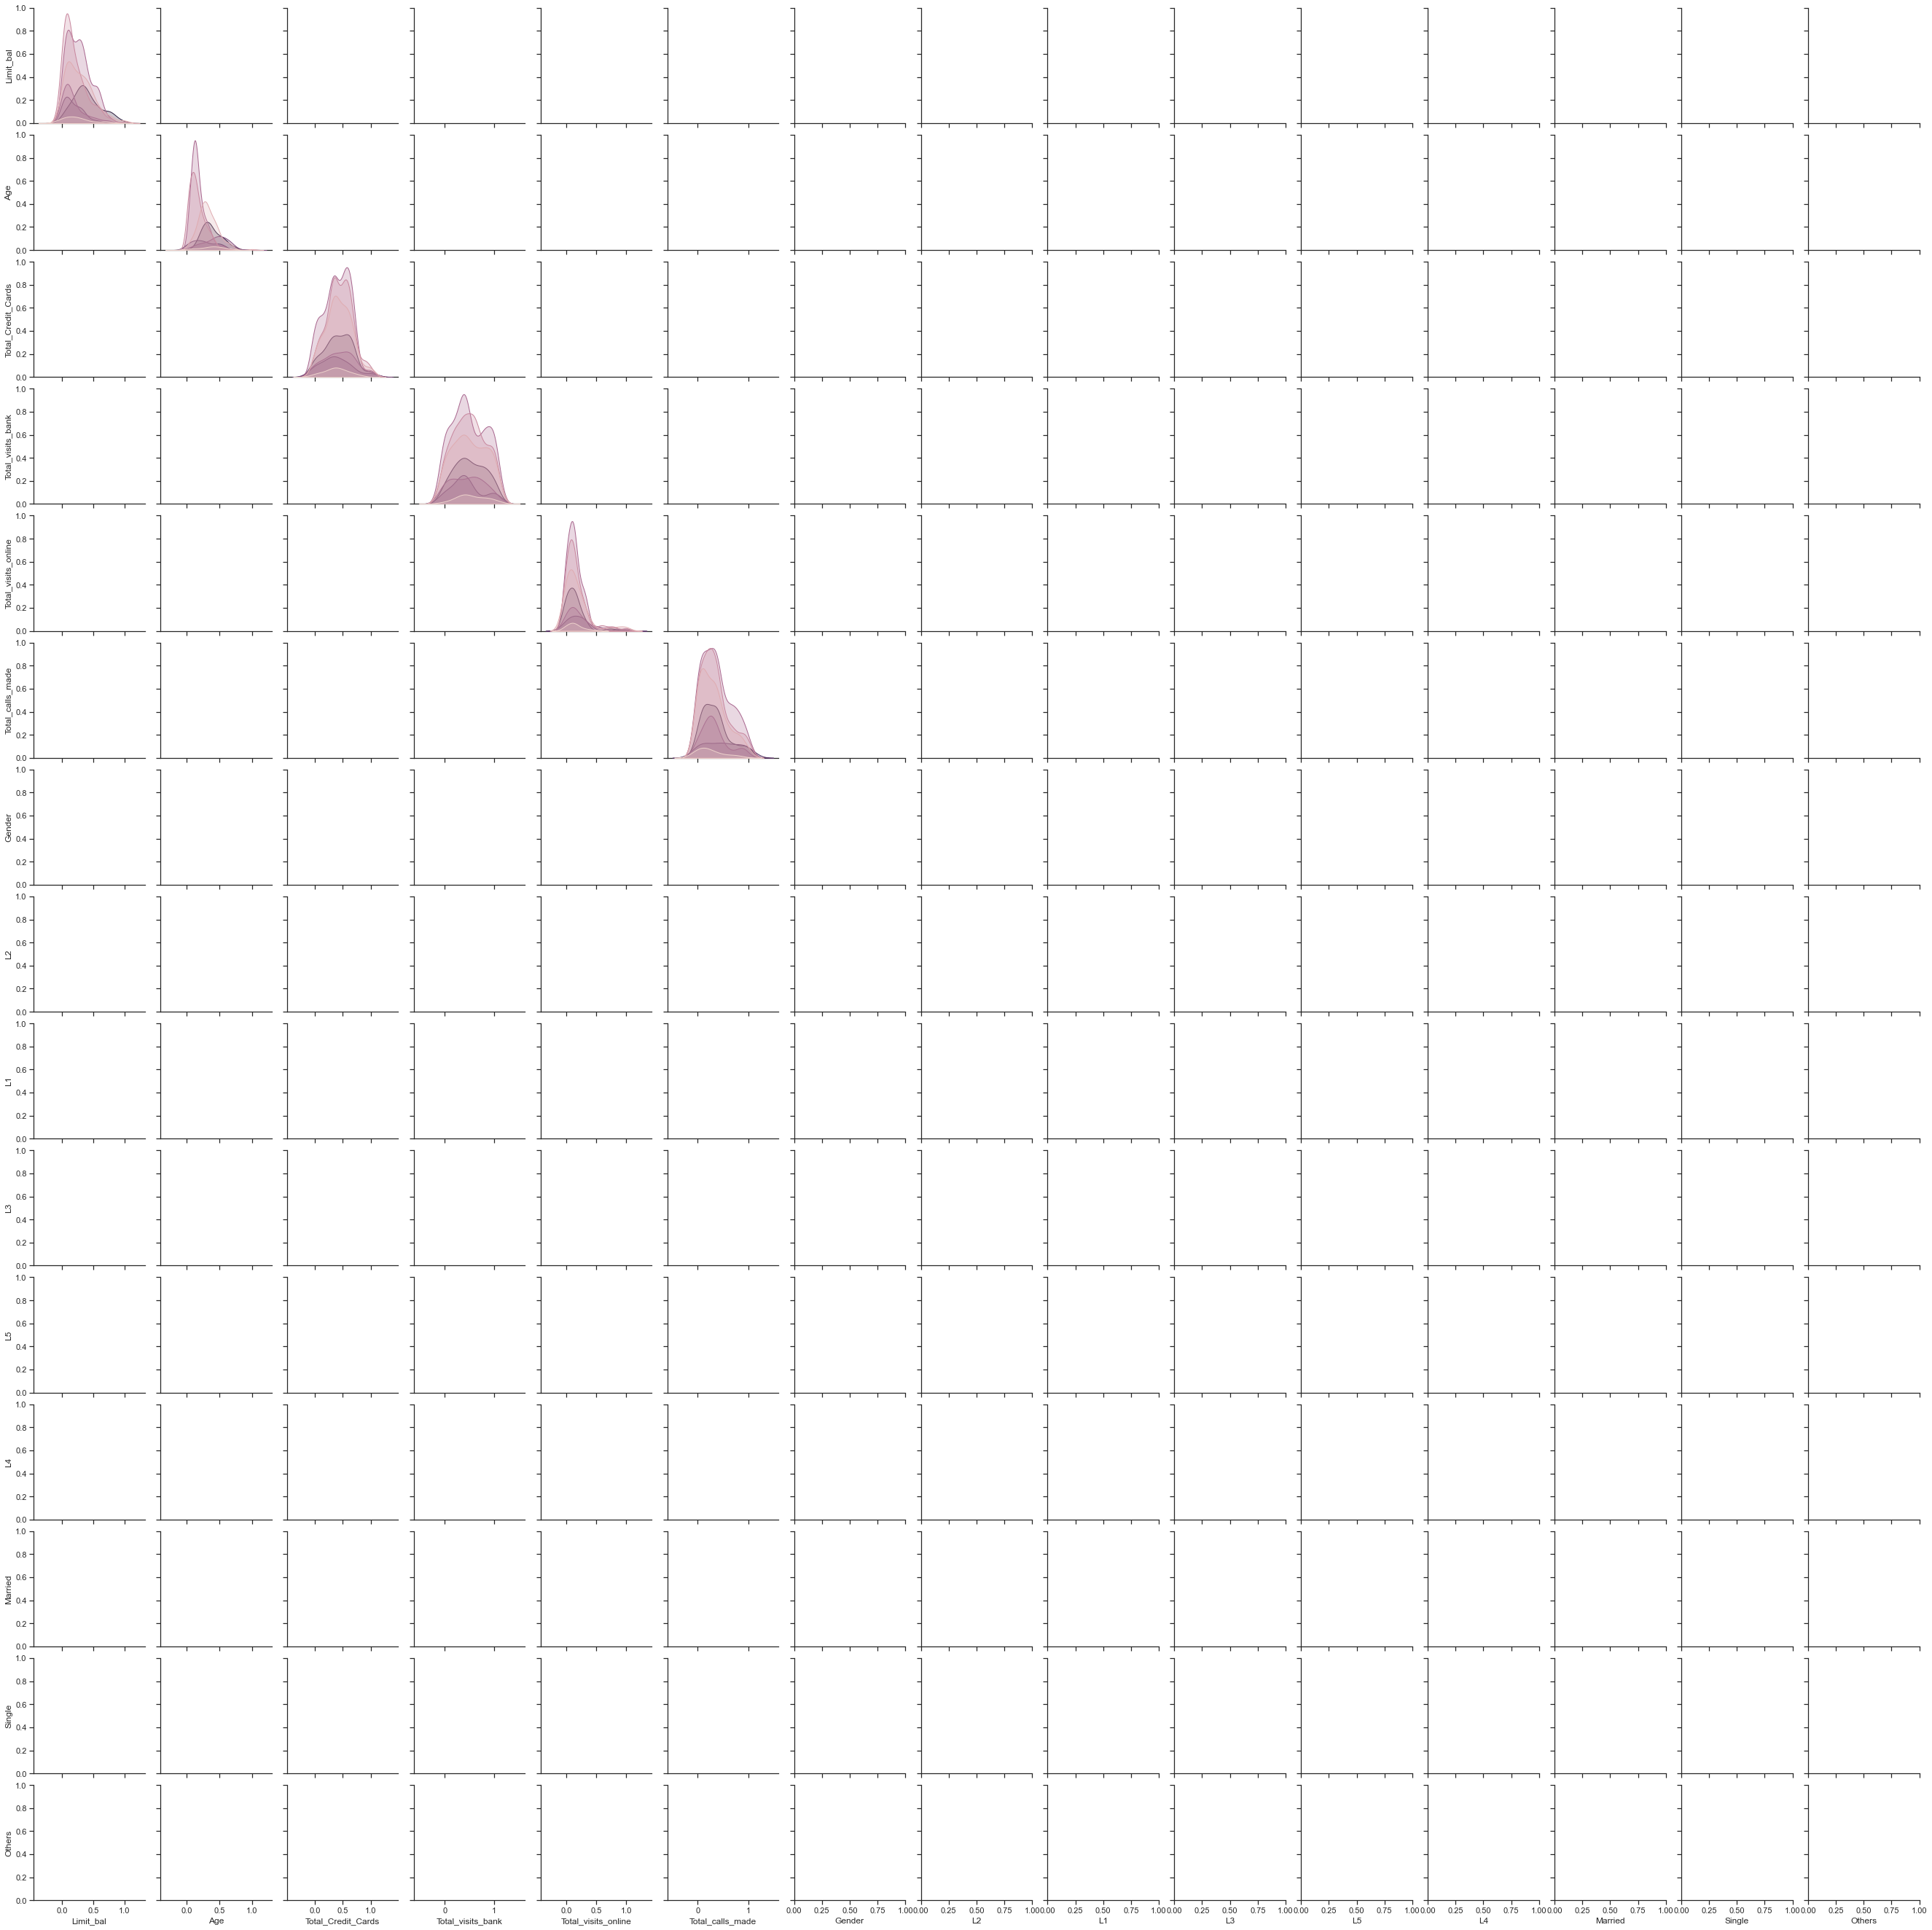

In [41]:
sns.set_theme(style="ticks")
sns.pairplot(data_DBSCAN, hue="Cluster")

### Aglomerative Clustering

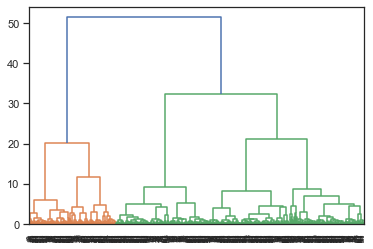

In [42]:
data_norm
X = data_norm
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

In [43]:
n_clusters = 3
agclustering = AgglomerativeClustering(n_clusters, affinity='euclidean', linkage='ward')
agclustering.fit(X)
labels = agclustering.labels_
data_AGC = data_norm
data_AGC['Cluster'] = labels
data_AGC

C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Gender,L2,L1,L3,L5,L4,Married,Single,Others,Cluster
0,0.016129,0.055556,0.111111,0.2,0.066667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,0.177419,0.092593,0.222222,0.0,0.666667,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,0.129032,0.240741,0.666667,0.2,0.200000,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.064516,0.666667,0.555556,0.0,0.800000,0.3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,0.064516,0.296296,0.222222,0.0,0.066667,0.8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,0.435484,0.333333,1.000000,0.2,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
635,0.451613,0.111111,1.000000,0.2,0.866667,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
636,0.290323,0.129630,0.777778,0.2,0.600000,0.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
637,0.112903,0.037037,1.000000,0.2,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2


In [50]:
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cols_number = data.to_numpy()
name_cols_number = data_AGC.columns
vista_x=7
vista_y=14
fig=plt.figure(figsize=(10,5))
for i in range(0,n_clusters):
    plt.scatter(cols_number[agclustering.labels_ == i, vista_x], cols_number[agclustering.labels_ == i, vista_y], s = 50, c = colors[i], alpha =0.3, label = 'Cluster '+ str(i))

plt.title('Clusters of clients')
plt.xlabel(name_cols_number[vista_x])
plt.ylabel(name_cols_number[vista_y])
plt.legend()
plt.show();

IndexError: index 14 is out of bounds for axis 1 with size 9

<Figure size 720x360 with 0 Axes>

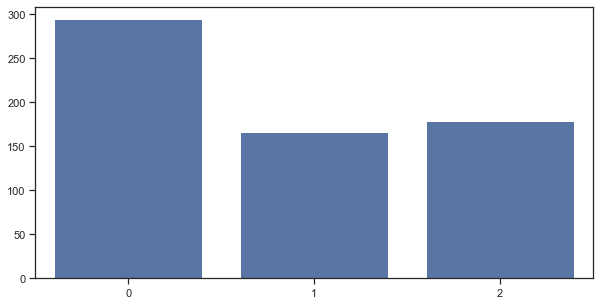

In [51]:
data_AGC=data_norm
data_AGC["Cluster"] =labels
cluster_distrib = data_AGC['Cluster'].value_counts()
fig=plt.figure(figsize=(10,5))
sns.barplot(x=cluster_distrib.index, y=cluster_distrib.values, color='b');

[0 1 2]


C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


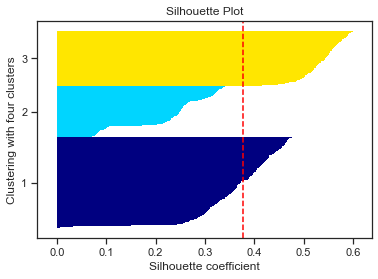

In [52]:
plot_silhouette(data = data_AGC,  labels = agclustering.labels_, ylabel = 'Clustering with four clusters')

TypeError: cannot perform var with type Sparse[float64, 0]

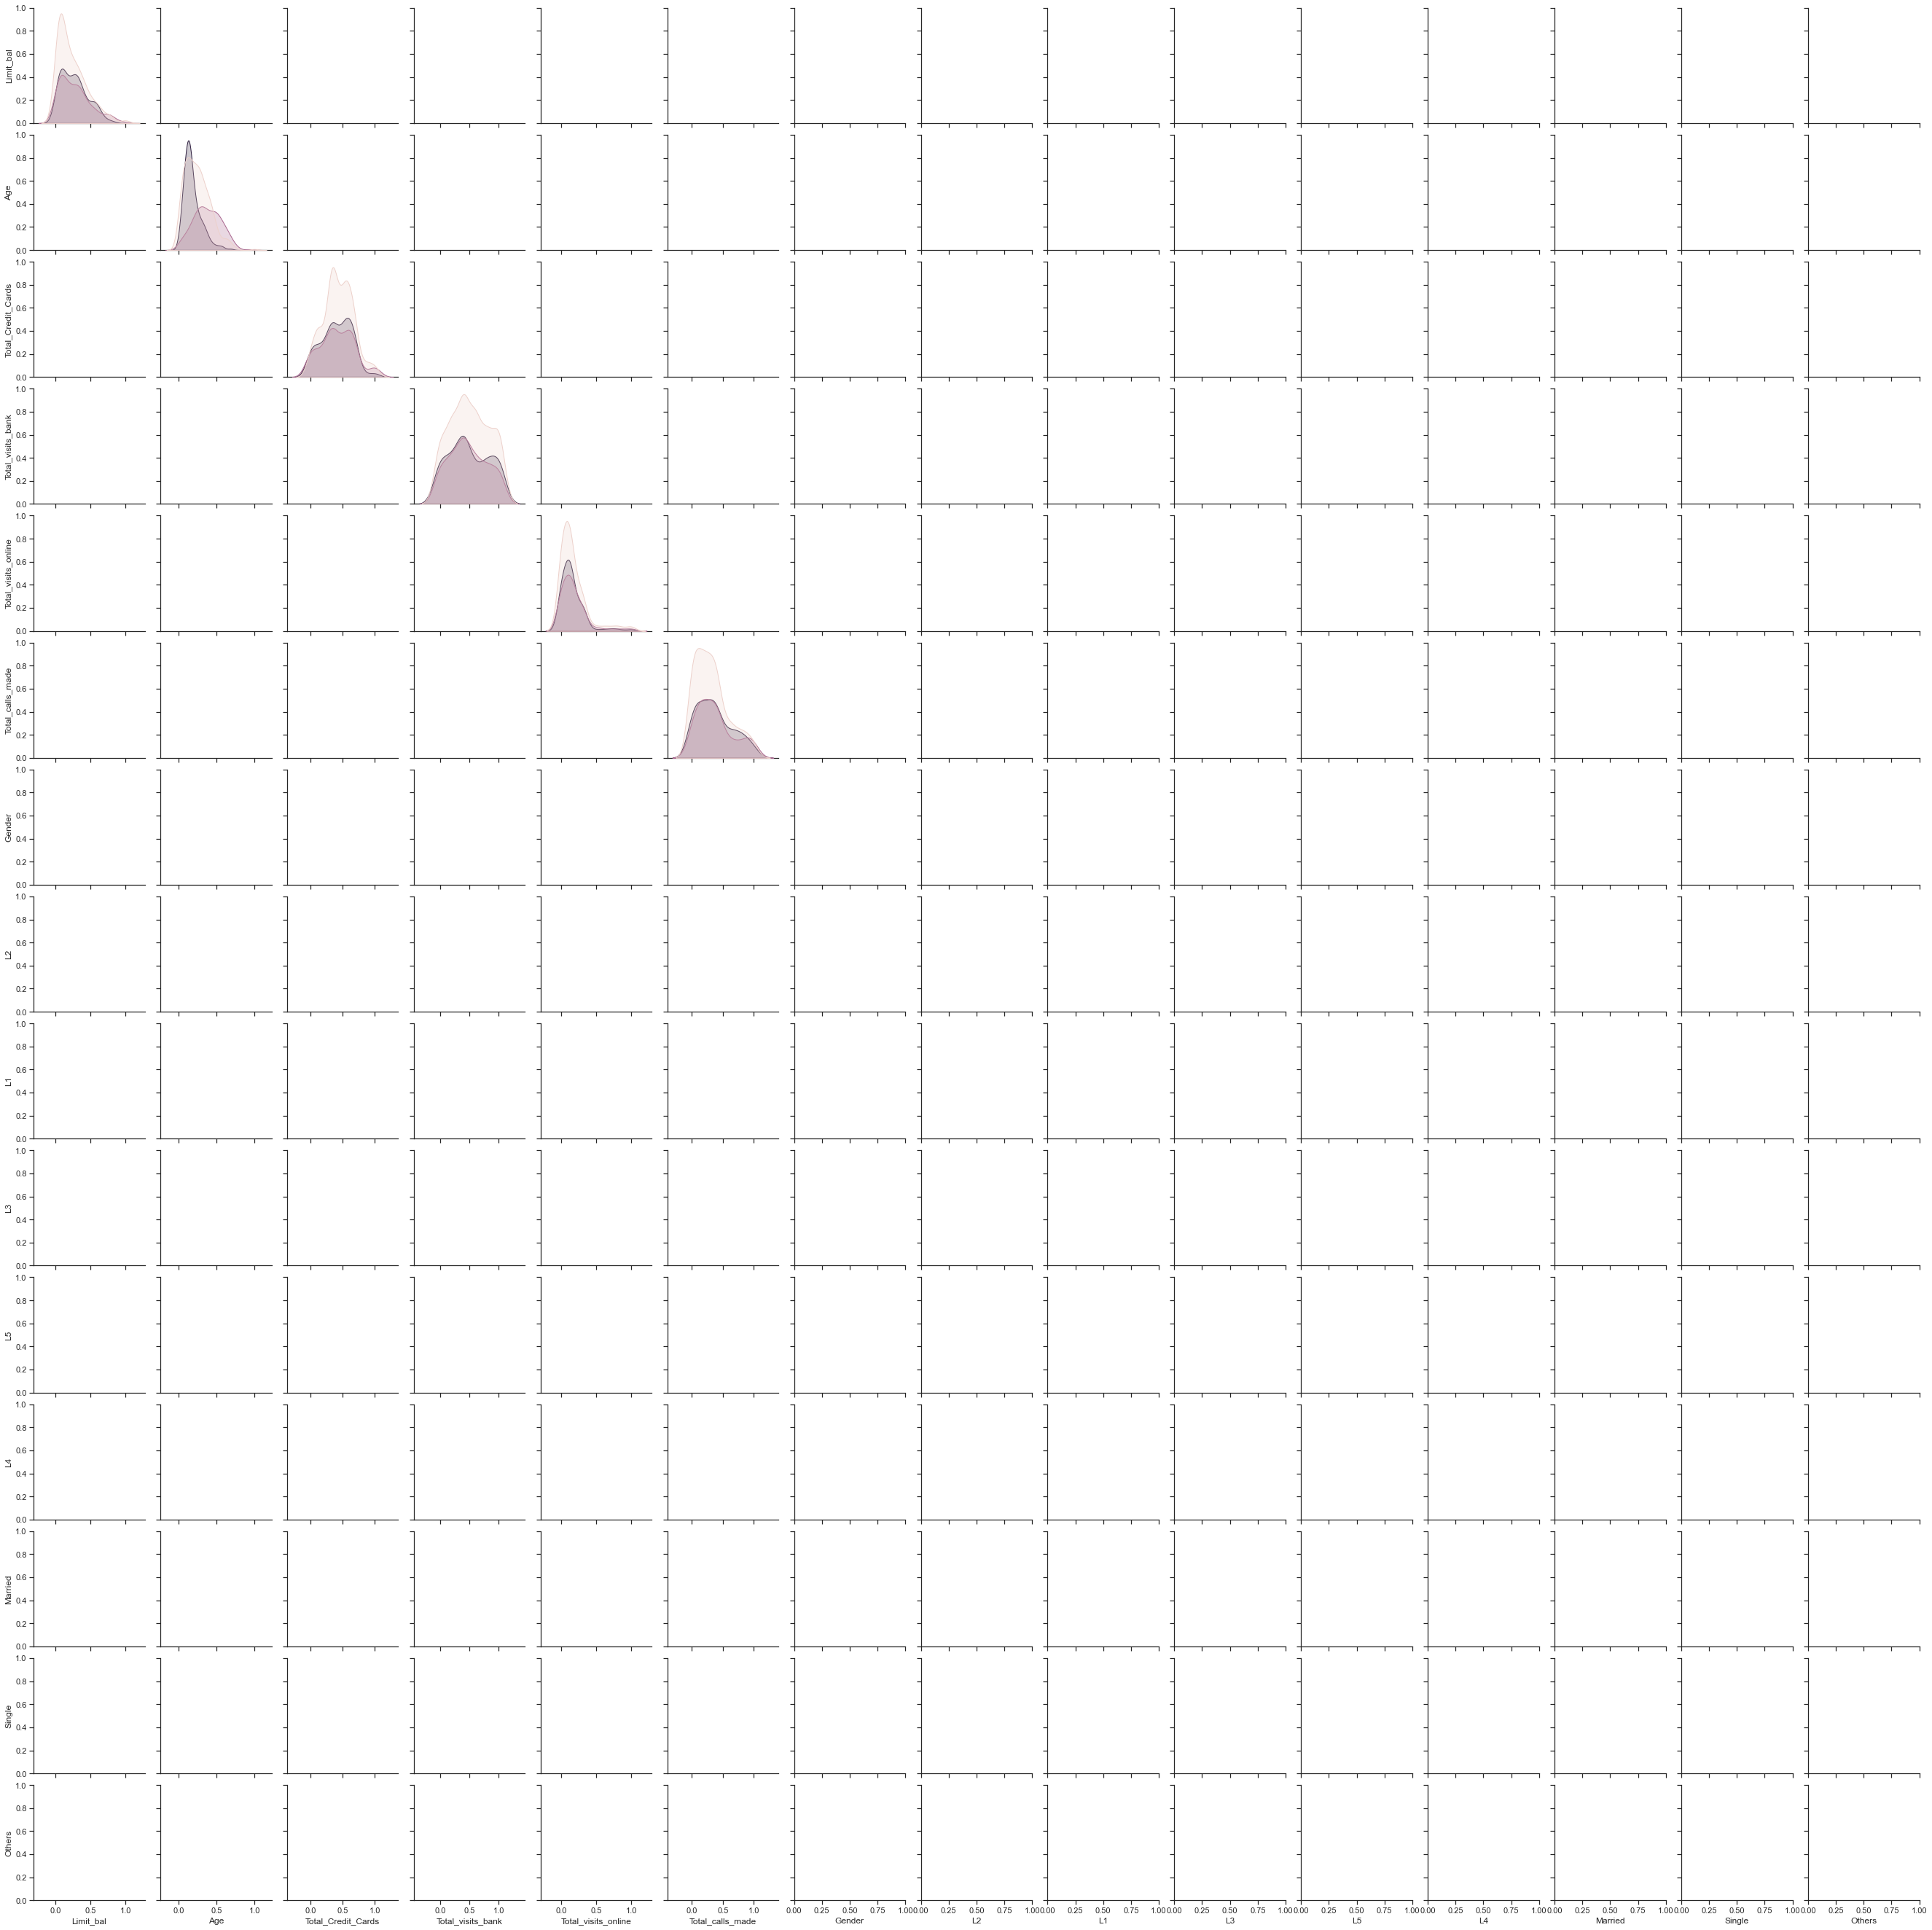

In [53]:
sns.set_theme(style="ticks")
sns.pairplot(data_AGC, hue="Cluster")

In [54]:
#dataAuxiliarAGC = data_AGC.drop(columns = ["Cluster"])
dataAuxiliarKmeans = dataKmeans.drop(columns = ["Cluster"])
dataAuxiliarKmeans

,Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Gender,L2,L1,L3,L5,L4,Married,Single,Others
0,0.016129,0.055556,0.111111,0.2,0.066667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.177419,0.092593,0.222222,0.0,0.666667,0.9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.129032,0.240741,0.666667,0.2,0.200000,0.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.064516,0.666667,0.555556,0.0,0.800000,0.3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.064516,0.296296,0.222222,0.0,0.066667,0.8,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,0.435484,0.333333,1.000000,0.2,0.666667,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
635,0.451613,0.111111,1.000000,0.2,0.866667,0.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
636,0.290323,0.129630,0.777778,0.2,0.600000,0.1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
637,0.112903,0.037037,1.000000,0.2,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [55]:
cluster_report(dataAuxiliarKmeans,kmeans.labels_, min_samples_leaf=2, pruning_level=0.001)

C:\Users\nicoc\anaconda3\lib\site-packages\sklearn\utils\validation.py:515: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


,class_name,instance_count,rule_list
0,0,180,[0.5] (L2 <= 0.5) and (L3 <= 0.5) and (Others > 0.5) and (L4 > 0.5)[1.0] (L2 > 0.5) and (Married <= 0.5)
1,1,156,[0.5] (L2 <= 0.5) and (L3 <= 0.5) and (Others <= 0.5) and (L1 > 0.5) and (Married <= 0.5)[1.0] (L2 <= 0.5) and (L3 <= 0.5) and (Others > 0.5) and (L4 <= 0.5)
4,2,80,[1.0] (L2 <= 0.5) and (L3 <= 0.5) and (Others <= 0.5) and (L1 <= 0.5)[1.0] (L2 > 0.5) and (Married > 0.5)
3,3,95,[1.0] (L2 <= 0.5) and (L3 > 0.5)
2,4,128,[1.0] (L2 <= 0.5) and (L3 <= 0.5) and (Others <= 0.5) and (L1 > 0.5) and (Married > 0.5)


### Descarga de datos resultado

In [60]:
data_AGC.to_csv()

',Limit_bal,Age,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Gender,L2,L1,L3,L5,L4,Married,Single,Others,Cluster\r\n0,0.016129032258064516,0.05555555555555558,0.1111111111111111,0.2,0.06666666666666667,0.0,0,0,1.0,0,0,0,1.0,0,0,2\r\n1,0.1774193548387097,0.09259259259259262,0.2222222222222222,0.0,0.6666666666666666,0.9,0,0,1.0,0,0,0,0,0,1.0,0\r\n2,0.12903225806451613,0.2407407407407407,0.6666666666666665,0.2,0.2,0.4,0,0,1.0,0,0,0,0,0,1.0,0\r\n3,0.06451612903225806,0.6666666666666667,0.5555555555555556,0.0,0.8,0.30000000000000004,1.0,0,1.0,0,0,0,1.0,0,0,2\r\n4,0.06451612903225806,0.2962962962962963,0.2222222222222222,0.0,0.06666666666666667,0.8,1.0,1.0,0,0,0,0,0,0,1.0,1\r\n5,0.7903225806451613,0.14814814814814814,0.4444444444444445,0.0,0.7333333333333333,0.2,1.0,1.0,0,0,0,0,0,0,1.0,1\r\n6,0.14516129032258063,0.03703703703703709,0.2222222222222222,0.0,0.06666666666666667,0.1,0,0,1.0,0,0,0,0,0,1.0,0\r\n7,0.2096774193548387,0.12962962962962965,0.1111111111111111